# Analysis of Instagram posts (pictures) using Google Vision API

## Step1: Data Preparation for Analysis

### 1.1 Import Required Libraries

In [1]:
import os
import pandas as pd
import instaloader
from google.cloud import vision

In [2]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stopword_list = stopwords.words('english')

import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")
from spacy.lang.en import stop_words

from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

### 1.2 Function to detect labels using google vision api

In [2]:
def detect_labels(path):
    client = vision.ImageAnnotatorClient.from_service_account_file('gcloud-vision-key.json')
    with open(path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    response = client.label_detection(image=image)
    labels = response.label_annotations

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    
    return [label.description for label in labels]

### 1.3 Function to extract required fields from the instagram dataset

In [3]:
def data_prep_to_df(folder: str = "Data", metadata_ext: str = ".json.xz"):
    L = instaloader.Instaloader()
    output_data = []

    for inner_folder in os.listdir(folder):
        files_in_folder = os.listdir(os.path.join(folder, inner_folder))
        metadata_file = next((f for f in files_in_folder if f.endswith(metadata_ext)), None)
        if not metadata_file:
            continue

        post_node = instaloader.structures.load_structure_from_file(
            L.context,
            os.path.join(folder, inner_folder, metadata_file)
        )
        
        post_likes = post_node.likes
        post_comments = post_node.comments
        profile_followers = post_node.owner_profile.followers
        post_caption = post_node.caption
        
        image_found = False
        for filename in files_in_folder:
            if (filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg")) and not image_found:
                image_location = os.path.join(folder, inner_folder, filename)
                labels = detect_labels(image_location)
                output_data.append([
                    post_node.owner_profile.username, 
                    image_location,
                    post_likes, 
                    post_comments,
                    profile_followers,
                    post_caption,
                    labels
                ])
                image_found = True

    df = pd.DataFrame(output_data, columns=["account_handle", "post_image_location", "post_likes", "post_comments", "profile_followers", "post_caption", "labels"])
    return df

### 1.4 Save the results to a dataframe

In [4]:
data = data_prep_to_df()

### 1.5 Save the results to a dataframe

This is done so that we don't have to run the google vision api again when the kernel is restarted and we can directly access the labels saved in the csv file.

In [17]:
data['labels_text'] = data['labels'].map(lambda x: " ".join(x))
data.to_csv('instagram_data_processed.csv', index=False)

## Step2: Create the LDA Model

In [3]:
#df = data.copy()
df = pd.read_csv('instagram_data_processed.csv')

### 2.1 Function for preprocessing text

In [4]:
def text_preprocessing(description):
    description = description.lower()
    description = re.sub('[^a-zA-Z]', ' ', description)
    description = re.sub(r'http\S+', '', description)
    description = re.sub(r'\*\*\*\*', '', description)
    tokenizer = RegexpTokenizer(r'\w+')
    description_words = tokenizer.tokenize(description)
    description_words = [word for word in description_words if word not in stopword_list]
    description = ' '.join(description_words)
    tokenizer = RegexpTokenizer(r'\w+')
    description_words = tokenizer.tokenize(description)
    lemmatizer = WordNetLemmatizer()
    description_words = [word for word in description_words if word not in stopword_list]
    description_words = [lemmatizer.lemmatize(word) for word in description_words]
    description = ' '.join(description_words)
    return description

In [5]:
df['labels_processed'] = df['labels_text'].apply(lambda x: text_preprocessing(x))

### 2.2 Create the labels and dictionary in a format that can be used by gensim

In [8]:
labels = [text.split() for text in df['labels_processed']]

dictionary = corpora.Dictionary(labels)
corpus = [dictionary.doc2bow(text) for text in labels]

### 2.3 Finding optimal number of topics for LDA

To determine the optimal number of topics for Latent Dirichlet Allocation (LDA) model, I am assessing models with varying numbers of topics ranging from 2 to 30. The coherence score, which measures the semantic similarity between high scoring words in the model, is used as the metric for this evaluation.

In [14]:
coherence_values = []
model_list = []
for num_topics in range(2, 31):
    model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=4)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=labels, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


In [20]:
coherence_values = pd.DataFrame(coherence_values, columns=['coherence_value'])
coherence_values['num_topics'] = range(2, 31)
coherence_values.to_csv('coherence_values.csv', index=False)

### 2.3.1 Plot Coherence Scores

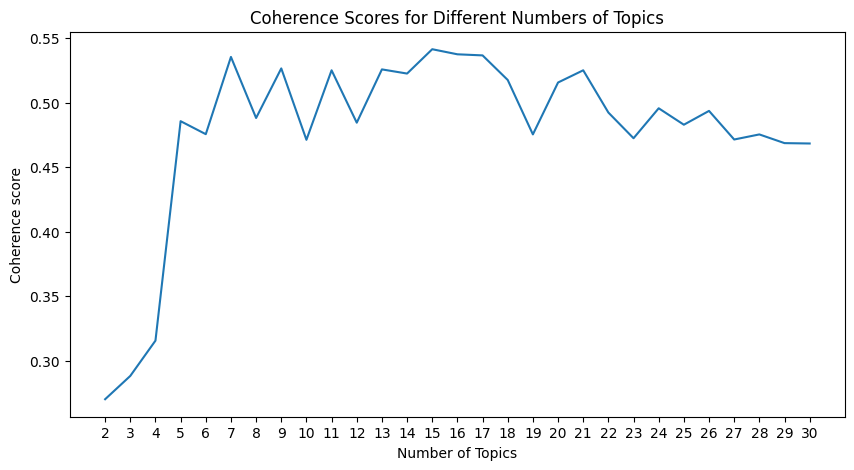

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 31), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.xticks(range(2, 31))
plt.grid(False)
plt.show()

From the plot, we can see that using number of topics=15 had the highest coherence score of 0.541, which was slightly better than the 7-topics model, which scored 0.535. Despite the marginally higher coherence score of the 15-topic model, I have opted for the 7-topic model. The rationale for this decision is the hypothesis that a smaller number of topics can provide more clearer and insightful distinctions between different topics. In this approach, I
am prioritizing depth and interpretability of results for actionable insights that can be given to the influencer based on this analysis.

## 2.4 LDA model with optimal number of topics

In [23]:
lda_model = models.LdaMulticore(corpus=corpus, num_topics=7, id2word=dictionary, passes=10, workers=4)

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words = lda_model.show_topic(t, topn=25)
    top_words_per_topic.append([", ".join([word for word, prop in top_words])])

df_topics = pd.DataFrame(top_words_per_topic, columns=["Words"])
df_topics.index.names = ['Topic']
df_topics.reset_index(inplace=True)
df_topics['Topic'] = df_topics['Topic'].apply(lambda x: f"Topic {x+1}")

df_topics.to_csv('lda_topic_words.csv', index=False)

## Step3: Analyzing Engagement vs Topics

### 3.1 Assign probability for each topic to labels for all posts in the dataset

In [25]:
topic_weights = []
for bow in corpus:
    doc_topics = lda_model.get_document_topics(bow, minimum_probability=0)
    doc_dist = [prob for _, prob in doc_topics]
    if len(doc_dist) < 7:
        doc_dist.extend([0] * (7 - len(doc_dist)))
    topic_weights.append(doc_dist)

df['topic_weights'] = topic_weights

### 3.2 Sort and Segment the data based on engagement (no of comments)

In [28]:
topics_df = pd.DataFrame(df['topic_weights'].tolist(), columns=[f'Topic {i+1}' for i in range(7)])
df = pd.concat([df, topics_df], axis=1)

df_sorted = df.sort_values(by='post_comments')
quartile_length = len(df_sorted) // 4
high_engagement = df_sorted.iloc[-quartile_length:]
low_engagement = df_sorted.iloc[:quartile_length]

### 3.3 Calculate Average Topic Weights for Each Quartile

In [30]:
high_means = high_engagement[[f'Topic {i+1}' for i in range(7)]].mean()
low_means = low_engagement[[f'Topic {i+1}' for i in range(7)]].mean()

In [35]:
comparison_df = pd.DataFrame({
    'High Engagement Avg': high_means,
    'Low Engagement Avg': low_means
})
comparison_df['Difference'] = comparison_df['High Engagement Avg'] - comparison_df['Low Engagement Avg']

In [36]:
topic_names = {
    'Topic 1': 'Formal Events and Fashion',
    'Topic 2': 'Personal Style and Beauty',
    'Topic 3': 'Sports and Athletics',
    'Topic 4': 'Outdoor and Leisure Activities',
    'Topic 5': 'Branding and Advertising',
    'Topic 6': 'Food and Dining',
    'Topic 7': 'Automotive and Technology'
}

comparison_df['Topic'] = comparison_df.index
comparison_df = comparison_df.reset_index(drop=True)
comparison_df['Topic'] = comparison_df['Topic'].map(topic_names)
comparison_df = comparison_df[['Topic', 'High Engagement Avg', 'Low Engagement Avg', 'Difference']]

In [37]:
comparison_df

,Topic,High Engagement Avg,Low Engagement Avg,Difference
0,Formal Events and Fashion,0.142927,0.141736,0.001191
1,Personal Style and Beauty,0.175599,0.219594,-0.043995
2,Sports and Athletics,0.204244,0.055186,0.149058
3,Outdoor and Leisure Activities,0.229926,0.196949,0.032977
4,Branding and Advertising,0.119126,0.165072,-0.045946
5,Food and Dining,0.068320,0.167304,-0.098984
6,Automotive and Technology,0.059858,0.054158,0.005699
